In [1]:
import os
from random import sample
import time
import cv2 as cv
from PIL import Image, ImageDraw
import numpy as np
import random

def rotate_image(img):
    angle = random.randint(-90, 90)
    scale = random.uniform(0.8, 1.8)
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv.getRotationMatrix2D(center, angle, scale)
    rotated_image = cv.warpAffine(img, matrix, (width, height))
    return rotated_image

def adjust_brightness(img):
    brightness_factor = random.uniform(0.5, 1.5)
    image_float = img.astype(np.float32)
    adjusted_image = image_float * brightness_factor
    adjusted_image = np.clip(adjusted_image, 0, 255)
    adjusted_image = adjusted_image.astype(np.uint8)
    return adjusted_image

def add_noise(img):
    mean = 0
    st = random.randint(10, 25)
    gauss = np.random.normal(mean, st, img.shape)
    noisy_img = np.clip(img + gauss, 0, 255)
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img

def color_jitter(img):
    jitter_list = ["b", "s", "c"]
    cj_type = random.choice(jitter_list)
    
    if cj_type == "b":
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)
        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
        
    elif cj_type == "s":
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)
        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast / 127 + 1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)

    return img

def random_mosaic(img_list, img_size=320):
    img1, img2, img3, img4 = img_list[0], img_list[1], img_list[2], img_list[3]
    
    height, width, channels = img1.shape
    mosaic_width = width
    mosaic_height = height
    mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
    
    xc, yc = [int(random.randint(img_size * 0.2, img_size * 0.8)) for _ in range(2)]
    
    start_x = np.random.randint(0, img_size - xc)
    start_y = np.random.randint(0, img_size - yc)
    cropped_region1 = img1[start_x:start_x+xc, start_y:start_y+yc, :]
    mosaic[0:xc, 0:yc, :] = cropped_region1
    
    start_x = np.random.randint(0, img_size - xc)
    start_y = np.random.randint(0, yc)
    cropped_region2 = img2[start_x:start_x+xc, start_y:start_y+img_size-yc, :]
    mosaic[0:xc, yc:img_size, :] = cropped_region2
    
    start_x = np.random.randint(0, xc)
    start_y = np.random.randint(0, img_size - yc)
    cropped_region3 = img3[start_x:start_x+img_size-xc, start_y:start_y+yc, :]
    mosaic[xc:img_size, 0:yc, :] = cropped_region3
    
    start_x = np.random.randint(0, xc)
    start_y = np.random.randint(0, yc)
    cropped_region4 = img4[start_x:start_x+img_size-xc, start_y:start_y+img_size-yc, :]
    mosaic[xc:img_size, yc:img_size, :] = cropped_region4 
    
    return Image.fromarray(cv.cvtColor(mosaic, cv.COLOR_BGR2RGB))

def switch_case(case, img_cv):
    Operate_Aug_dict = {
        'Noise': add_noise(img_cv),
        'dark': adjust_brightness(img_cv),
        'rotation': rotate_image(img_cv),
        'colorjitter': color_jitter(img_cv),
    }
    return Operate_Aug_dict.get(case)


def augment_and_save(original_img_path, augmented_folder):
    img = cv.imread(original_img_path)
    img_list = [rotate_image(img), adjust_brightness(img), add_noise(img), color_jitter(img)]
    
    # 随机选取4种处理方法
    Aug_f = ['Noise', 'dark', 'rotation', 'colorjitter']
    Aug_ch = sample(Aug_f, 4)
    for j, j_value in enumerate(range(4)):
        img_list[j] = switch_case(Aug_ch[j], img_list[j])
    
    result = random_mosaic(img_list)
    
    # 将结果保存
    result.save(os.path.join(augmented_folder, f"{int(float(time.time()) * 1000)}.jpg"))


In [2]:
def main():
    # 指定原始图像文件夹和增强后保存的文件夹
    original_images_folder = "resized_labeled_images"
    augmented_images_folder = "augmented_labeled_images"

    # 如果保存文件夹不存在，创建它
    if not os.path.exists(augmented_images_folder):
        os.makedirs(augmented_images_folder)

    # 获取原始图像文件列表
    original_image_files = [f for f in os.listdir(original_images_folder) if f.endswith(".jpg")]

    # 对每个原始图像进行增强并保存
    for original_image_file in original_image_files:
        original_image_path = os.path.join(original_images_folder, original_image_file)
        augment_and_save(original_image_path, augmented_images_folder)

if __name__ == "__main__":
    main()


# 2. 同时增强图像和标签；

In [3]:
import random
import cv2 as cv
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def rescale_image_and_labels(img, labels):
    # 随机选择缩放因子
    scale_factor = random.uniform(0.7, 2.0) 
    # 缩放图像
    height, width = img.shape[:2]
    rescaled_img = cv.resize(img, (int(width * scale_factor), int(height * scale_factor)))

    # 缩放标签
    rescaled_labels = []
    for label in labels:
        rescaled_labels.append({
            'label': label['label'],
            'left': label['left'] * scale_factor,
            'top': label['top'] * scale_factor,
            'width': label['width'] * scale_factor,
            'height': label['height'] * scale_factor
        })
        
    # 对原始图像进行补足或者裁剪；
    if scale_factor < 1.0:
        # 补足
        top_pad = int((1.0 - scale_factor) * height)
        bottom_pad = int((1.0 - scale_factor) * height)
        left_pad = int((1.0 - scale_factor) * width)
        right_pad = int((1.0 - scale_factor) * width)
        rescaled_img = cv.copyMakeBorder(rescaled_img, top_pad, bottom_pad, left_pad, right_pad, cv.BORDER_CONSTANT, value=[0, 0, 0])
        for label in rescaled_labels:
            label['top'] += top_pad
            label['left'] += left_pad
            
    else:
        # 计算裁剪的位置
        crop_top = int((height * scale_factor - height) / 2)
        crop_bottom = int(height * scale_factor - height - crop_top)
        crop_left = int((width * scale_factor - width) / 2)
        crop_right = int(width * scale_factor - width - crop_left)

        # 裁剪图像
        rescaled_img = rescaled_img[crop_top:height + crop_top, crop_left:width + crop_left]

        # 裁剪标签
        for label in rescaled_labels:
            label['top'] -= crop_top
            label['top'] = max(0, label['top'])
            label['left'] -= crop_left
            label['left'] = max(0, label['left'])
            label_right = min(label['left'] + label['width'], width)
            label_bottom = min(label['top'] + label['height'], height)
            label['width'] = label_right - label['left']
            label['height'] = label_bottom - label['top']
            if label['width'] <= 0 or label['height'] <= 0:
                labels.remove(label)
        print(label['left'], label['top'], label_right, label_bottom)

    return rescaled_img, rescaled_labels

In [4]:
def adjust_brightness(img, labels):
    brightness_factor = random.uniform(0.5, 1.5)
    image_float = img.astype(np.float32)
    adjusted_image = image_float * brightness_factor
    adjusted_image = np.clip(adjusted_image, 0, 255)
    adjusted_image = adjusted_image.astype(np.uint8)
    return adjusted_image, labels

def add_noise(img, labels):
    mean = 0
    st = random.randint(10, 25)
    gauss = np.random.normal(mean, st, img.shape)
    noisy_img = np.clip(img + gauss, 0, 255)
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img, labels

def color_jitter(img, labels):
    jitter_list = ["b", "s", "c"]
    cj_type = random.choice(jitter_list)
    
    if cj_type == "b":
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)
        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
        
    elif cj_type == "s":
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)
        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast / 127 + 1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)

    return img, labels

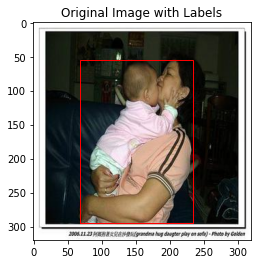

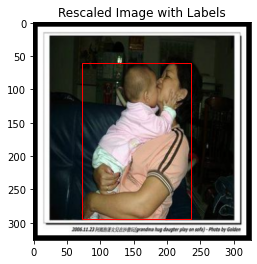

In [5]:
# 示例用法
img = cv.imread('./resized_labeled_images/018e2730-03da-4ad2-a9e5-7477286e5090.jpg')
json_file_path = './resized_labeled_images/018e2730-03da-4ad2-a9e5-7477286e5090.json'

def read_labels_from_json(json_file_path):
    with open(json_file_path, 'r') as json_file:
        labels = json.load(json_file)
    return labels

labels = read_labels_from_json(json_file_path)

rescaled_img, rescaled_labels = rescale_image_and_labels(img, labels)
rescaled_img1, rescaled_labels1 = adjust_brightness(img, labels)
rescaled_img2, rescaled_labels2 = add_noise(img, labels)
rescaled_img3, rescaled_labels3 = color_jitter(img, labels)

# 显示原始图像和标签
fig, ax = plt.subplots()
ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

for label in labels:
    rect = patches.Rectangle(
        (label['left'], label['top']),
        label['width'], label['height'],
        linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

plt.title('Original Image with Labels')
plt.show()

# 显示缩放后的图像和标签
fig, ax = plt.subplots()
ax.imshow(cv.cvtColor(rescaled_img, cv.COLOR_BGR2RGB))

for label in rescaled_labels:
    rect = patches.Rectangle(
        (round(label['left']), round(label['top'])),
        round(label['width']), round(label['height']),
        linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    
plt.title('Rescaled Image with Labels')
plt.show()

[{'label': 'person', 'left': 38.9086528, 'top': 0, 'width': 93.0913472, 'height': 198}, {'label': 'person', 'left': 0, 'top': 198, 'width': 77.7310176, 'height': 118.56819200000001}, {'label': 'person', 'left': 89.385536, 'top': 198, 'width': 42.614464, 'height': 103.4637056}, {'label': 'person', 'left': 221.1434944, 'top': 0, 'width': 77.6612576, 'height': 102.3422624}]


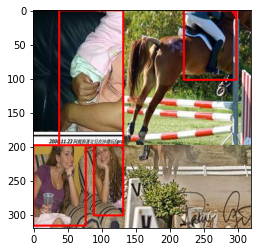

In [9]:
from PIL import Image
import random
import json
import numpy as np
import copy
import random
import cv2 as cv
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def random_mosaic(img_list, labels, img_size=320):
    img1, img2, img3, img4 = img_list[0], img_list[1], img_list[2], img_list[3]
    label1, label2, label3, label4 = labels[0], labels[1], labels[2], labels[3]
    
    height = width =320
    mosaic_width = width
    mosaic_height = height
    mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
    
    # xc, yc: center of Mosaic (4 different images combined)
    xc, yc = [int(random.randint(img_size * 0.2, img_size * 0.8)) for _ in range(2)]
    
    # 随机从img1中裁剪出一块（xc, yc）大小的区域，放到mosaic中
    start_y = np.random.randint(0, img_size - yc)
    start_x = np.random.randint(0, img_size - xc)
    cropped_region1 = img1[start_y:start_y+yc,start_x:start_x+xc, :]
    mosaic[0:yc, 0:xc, :] = cropped_region1
    cropped_boxes = []
    
    height_thresh = 0.4
    width_thresh = 0.4
    # # crop img1 label:
    for box in label1:
        # 计算裁剪后的 bounding box 坐标
        box_left = box["left"]
        box_top = box["top"]
        box_right = box["left"] + box['width']
        box_bottom = box["top"] + box['height']
        slice_right = start_x + xc
        slice_bottom = start_y + yc
        
        if box_right <= start_x or box_bottom <= start_y or box_left >= slice_right or box_top >= slice_bottom:
            continue
        
        if box_left <= start_x: 
            new_left = 0
        else: 
            new_left = box_left - start_x
        
        if box_top <= start_y:
            new_top = 0
        else:
            new_top = box_top - start_y

        new_right = min(new_left+box['width'], xc)
        new_bottom = min(new_top+box['height'], yc)
    
        new_width = new_right - new_left
        new_height = new_bottom - new_top
        
        if new_width <= box['width'] * width_thresh or new_height <=box['height'] * height_thresh:
            continue

        # 构建新的 bounding box 字典
        new_box = {
            "label": box["label"],
            "left": new_left,
            "top": new_top,
            "width": new_width,
            "height": new_height
        }

        # 将新的 bounding box 添加到列表中
        cropped_boxes.append(new_box)
    
    
    # 随机从img2中裁剪出一块（xc, img_size-yc）大小的区域，放到mosaic中
    start_y = np.random.randint(0, yc)
    start_x = np.random.randint(0, img_size-xc)
    cropped_region2 = img2[start_y:start_y+img_size-yc, start_x:start_x+xc, :]
    mosaic[yc:img_size, 0:xc, :] = cropped_region2
    # crop img2 label:
    for box in label2:
        # 计算裁剪后的 bounding box 坐标
        box_left = box["left"]
        box_top = box["top"]
        box_right = box["left"] + box['width']
        box_bottom = box["top"] + box['height']
        slice_left = start_x
        slice_top = start_y
        slice_right = start_x + xc
        slice_bottom = start_y + img_size-yc
        
        if box_right <= slice_left or box_bottom <= slice_top or box_left >= slice_right or box_top >= slice_bottom:
            continue
        
        if box_left <= slice_left: 
            new_left = 0 
        else: 
            new_left = box_left - start_x
        
        if box_top <= start_y:
            new_top = 0 
        else:
            new_top = box_top - start_y

        new_right = min(new_left+box['width'], xc)
        new_bottom = min(new_top+box['height'], img_size-yc)
    
        new_width = new_right - new_left
        new_height = new_bottom - new_top

        if new_width <= box['width'] * width_thresh or new_height <=box['height'] * height_thresh:
            continue
        
        # 构建新的 bounding box 字典
        new_box = {
            "label": box["label"],
            "left": new_left,
            "top": new_top+yc,
            "width": new_width,
            "height": new_height
        }

        # 将新的 bounding box 添加到列表中
        cropped_boxes.append(new_box)
    
    # 随机从img3中裁剪出一块（img_size-xc, start_y+yc）大小的区域，放到mosaic中
    start_y = np.random.randint(0, img_size - yc)
    start_x = np.random.randint(0, xc)
    cropped_region3 = img3[start_y:start_y+yc, start_x:start_x+img_size-xc,:]
    mosaic[0:yc, xc:img_size, :] = cropped_region3
    # crop img2 label:
    for box in label3:
        # 计算裁剪后的 bounding box 坐标
        box_left = box["left"]
        box_top = box["top"]
        box_right = box["left"] + box['width']
        box_bottom = box["top"] + box['height']
        slice_left = start_x
        slice_top = start_y
        slice_right = start_x + img_size-xc
        slice_bottom = start_y + yc
        
        if box_right <= slice_left or box_bottom <= slice_top or box_left >= slice_right or box_top >= slice_bottom:
            continue
        
        if box_left <= slice_left: 
            new_left = 0 
        else: 
            new_left = box_left - start_x
        
        if box_top <= start_y:
            new_top = 0 
        else:
            new_top = box_top - start_y

        new_right = min(new_left+box['width'], img_size-xc)
        new_bottom = min(new_top+box['height'], yc)
    
        new_width = new_right - new_left
        new_height = new_bottom - new_top

        if new_width <= box['width'] * width_thresh or new_height <=box['height'] * height_thresh:
            continue
        
        # 构建新的 bounding box 字典
        new_box = {
            "label": box["label"],
            "left": new_left+xc,
            "top": new_top,
            "width": new_width,
            "height": new_height
        }

        # 将新的 bounding box 添加到列表中
        cropped_boxes.append(new_box)
    
    # 随机从img4中裁剪出一块（img_size-xc, img_size-yc）大小的区域，放到mosaic中
    start_x = np.random.randint(0, xc)
    start_y = np.random.randint(0, yc)
    cropped_region4 = img4[start_y:start_y+img_size-yc, start_x:start_x+img_size-xc, :]
    mosaic[yc:img_size, xc:img_size, :] = cropped_region4 
    # crop img4 label:
    for box in label4:
        # 计算裁剪后的 bounding box 坐标
        box_left = box["left"]
        box_top = box["top"]
        box_right = box["left"] + box['width']
        box_bottom = box["top"] + box['height']
        slice_left = start_x
        slice_top = start_y
        slice_right = start_x + img_size-xc
        slice_bottom = start_y + img_size-yc
        
        if box_right <= slice_left or box_bottom <= slice_top or box_left >= slice_right or box_top >= slice_bottom:
            continue
        
        if box_left <= slice_left: 
            new_left = 0 
        else: 
            new_left = box_left - start_x
        
        if box_top <= start_y:
            new_top = 0 
        else:
            new_top = box_top - start_y

        new_right = min(new_left+box['width'], img_size-xc)
        new_bottom = min(new_top+box['height'], img_size-yc)
    
        new_width = new_right - new_left
        new_height = new_bottom - new_top
        
        if new_width <= box['width'] * width_thresh or new_height <=box['height'] * height_thresh:
            continue

        # 构建新的 bounding box 字典
        new_box = {
            "label": box["label"],
            "left": new_left+xc,
            "top": new_top+yc,
            "width": new_width,
            "height": new_height
        }

        # 将新的 bounding box 添加到列表中
        cropped_boxes.append(new_box)
    
    # return Image.fromarray(cv.cvtColor(mosaic, cv.COLOR_BGR2RGB)), cropped_boxes
    return cv.cvtColor(mosaic, cv.COLOR_BGR2RGB), cropped_boxes


# 示例用法
image_files = ["./resized_labeled_images/018e2730-03da-4ad2-a9e5-7477286e5090.jpg", 
               "./resized_labeled_images/02b7c881-f190-4767-b93e-dd923c600764.jpg",
               "./resized_labeled_images/050ef684-ae7c-4297-a0b3-27022bfbf77c.jpg",
               "./resized_labeled_images/0529e82a-f746-4d75-a5f1-3615488c86f9.jpg"]
label_files = ["./resized_labeled_images/018e2730-03da-4ad2-a9e5-7477286e5090.json", 
               "./resized_labeled_images/02b7c881-f190-4767-b93e-dd923c600764.json",
               "./resized_labeled_images/050ef684-ae7c-4297-a0b3-27022bfbf77c.json",
               "./resized_labeled_images/0529e82a-f746-4d75-a5f1-3615488c86f9.json"]

# 解析label文件
import cv2 as cv

def parse_label_file(label_file):
    with open(label_file, 'r') as f:
        return json.load(f)
labels = [parse_label_file(label_file) for label_file in label_files]
image_files = [cv.imread(image_file) for image_file in image_files]

mosaic_image, mosaic_labels = random_mosaic(image_files, labels)
# mosaic_image.show()
print(mosaic_labels)
# 遍历 bounding boxes 并画出每个 bounding box
for label in mosaic_labels:
    left = int(label["left"])
    top = int(label["top"])
    right = int(label["left"] + label["width"])
    bottom = int(label["top"] + label["height"])

    # 画矩形框
    cv.rectangle(mosaic_image, (left, top), (right, bottom), (255, 0, 0), 2)

# 显示图像
plt.imshow(mosaic_image)
plt.show()

['resized_labeled_images\\96df7c90-105d-48d6-9ddc-eb3fcf2d1914.jpg', 'resized_labeled_images\\4270da3b-1a1f-46d6-a38f-af99ae433d5e.jpg', 'resized_labeled_images\\adca6caf-b3ce-4207-9ab3-9f8bfd8b6eed.jpg', 'resized_labeled_images\\430f007a-fcb0-4d43-ae5b-a8ab9c032d7b.jpg'] ['resized_labeled_images\\96df7c90-105d-48d6-9ddc-eb3fcf2d1914.json', 'resized_labeled_images\\4270da3b-1a1f-46d6-a38f-af99ae433d5e.json', 'resized_labeled_images\\adca6caf-b3ce-4207-9ab3-9f8bfd8b6eed.json', 'resized_labeled_images\\430f007a-fcb0-4d43-ae5b-a8ab9c032d7b.json']
[{'label': 'person', 'left': 0, 'top': 0, 'width': 92, 'height': 147}, {'label': 'person', 'left': 30.195776000000023, 'top': 149.79319040000001, 'width': 61.80422399999998, 'height': 158.3020416}, {'label': 'person', 'left': 0, 'top': 147, 'width': 67.31632, 'height': 102.7584832}, {'label': 'person', 'left': 92.1431008, 'top': 0, 'width': 117.13007040000001, 'height': 147}, {'label': 'person', 'left': 287.341184, 'top': 20.874486399999995, 'wid

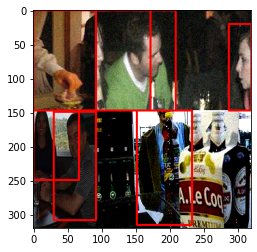

['resized_labeled_images\\8af74952-f145-4898-9a77-03e2c1707bd1.jpg', 'resized_labeled_images\\4c99669d-b9bd-40c1-b4f7-99183e95785c.jpg', 'resized_labeled_images\\cba7d6d0-a46c-42dc-8489-7c3c3dd56eb4.jpg', 'resized_labeled_images\\e78b86dc-bac1-4b60-9eaf-17e95bc56048.jpg'] ['resized_labeled_images\\8af74952-f145-4898-9a77-03e2c1707bd1.json', 'resized_labeled_images\\4c99669d-b9bd-40c1-b4f7-99183e95785c.json', 'resized_labeled_images\\cba7d6d0-a46c-42dc-8489-7c3c3dd56eb4.json', 'resized_labeled_images\\e78b86dc-bac1-4b60-9eaf-17e95bc56048.json']
[{'label': 'person', 'left': 118, 'top': 0, 'width': 169.76915200000002, 'height': 180}, {'label': 'person', 'left': 199.3988896, 'top': 210.3298144, 'width': 120.60111040000001, 'height': 109.6701856}]


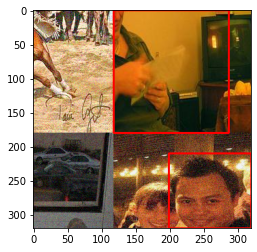

['resized_labeled_images\\0529e82a-f746-4d75-a5f1-3615488c86f9.jpg', 'resized_labeled_images\\c2384ea8-ceae-4531-85d3-fb9f771449b0.jpg', 'resized_labeled_images\\19968f19-fa5d-4b10-9dd9-ec2e52b6d8b6.jpg', 'resized_labeled_images\\70969184-5f6d-4a3d-9d25-829e370e0b26.jpg'] ['resized_labeled_images\\0529e82a-f746-4d75-a5f1-3615488c86f9.json', 'resized_labeled_images\\c2384ea8-ceae-4531-85d3-fb9f771449b0.json', 'resized_labeled_images\\19968f19-fa5d-4b10-9dd9-ec2e52b6d8b6.json', 'resized_labeled_images\\70969184-5f6d-4a3d-9d25-829e370e0b26.json']
[{'label': 'person', 'left': 0, 'top': 4.143891199999999, 'width': 60.019865599999996, 'height': 70.362336}, {'label': 'person', 'left': 0, 'top': 203, 'width': 85, 'height': 117}, {'label': 'person', 'left': 85, 'top': 0, 'width': 235, 'height': 203}, {'label': 'person', 'left': 85, 'top': 203, 'width': 49.8898112, 'height': 78.7543168}, {'label': 'person', 'left': 169.904352, 'top': 203, 'width': 109.4619936, 'height': 117}]


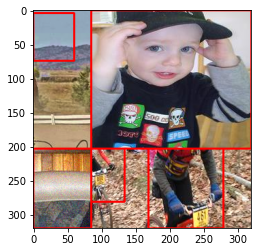

['resized_labeled_images\\3a52a223-580e-47a7-8041-fb69b2473fa4.jpg', 'resized_labeled_images\\6e7a913e-8985-4626-b700-17b1440b32ff.jpg', 'resized_labeled_images\\68f48b27-4c8c-4f3b-9479-2816dfbe8fee.jpg', 'resized_labeled_images\\c2384ea8-ceae-4531-85d3-fb9f771449b0.jpg'] ['resized_labeled_images\\3a52a223-580e-47a7-8041-fb69b2473fa4.json', 'resized_labeled_images\\6e7a913e-8985-4626-b700-17b1440b32ff.json', 'resized_labeled_images\\68f48b27-4c8c-4f3b-9479-2816dfbe8fee.json', 'resized_labeled_images\\c2384ea8-ceae-4531-85d3-fb9f771449b0.json']
[{'label': 'person', 'left': 0, 'top': 152, 'width': 184, 'height': 168}, {'label': 'person', 'left': 184, 'top': 53.4151232, 'width': 111.47001599999999, 'height': 86.416512}, {'label': 'person', 'left': 184, 'top': 184.5627968, 'width': 136, 'height': 135.4372032}]


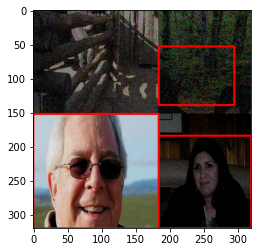

['resized_labeled_images\\954f7f77-ce2b-4ad1-8d5f-19e98400cad0.jpg', 'resized_labeled_images\\14e7bd00-8d6f-4b39-a797-e00a514cfffb.jpg', 'resized_labeled_images\\682c70b5-3e56-4be9-81bd-27a9a4dae6d7.jpg', 'resized_labeled_images\\977fc9e4-8837-4985-b989-0aa6081e60a6.jpg'] ['resized_labeled_images\\954f7f77-ce2b-4ad1-8d5f-19e98400cad0.json', 'resized_labeled_images\\14e7bd00-8d6f-4b39-a797-e00a514cfffb.json', 'resized_labeled_images\\682c70b5-3e56-4be9-81bd-27a9a4dae6d7.json', 'resized_labeled_images\\977fc9e4-8837-4985-b989-0aa6081e60a6.json']
[{'label': 'person', 'left': 100.5293952, 'top': 130.43973440000002, 'width': 28.419104000000004, 'height': 47.35517440000001}, {'label': 'person', 'left': 132.19165759999998, 'top': 229, 'width': 95.12184, 'height': 91}, {'label': 'person', 'left': 214.4413184, 'top': 229, 'width': 104.03381440000001, 'height': 91}]


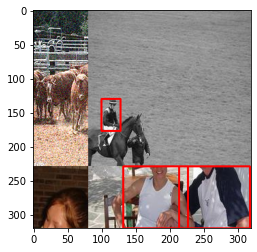

['resized_labeled_images\\0529e82a-f746-4d75-a5f1-3615488c86f9.jpg', 'resized_labeled_images\\33b92f75-edc1-4ca3-bf2c-dd33e2e88b80.jpg', 'resized_labeled_images\\f57c2a3a-2422-41e5-8ff4-07e4fbbf4015.jpg', 'resized_labeled_images\\b47d9c8b-3eb8-4e6e-9943-9b9d5028a1cc.jpg'] ['resized_labeled_images\\0529e82a-f746-4d75-a5f1-3615488c86f9.json', 'resized_labeled_images\\33b92f75-edc1-4ca3-bf2c-dd33e2e88b80.json', 'resized_labeled_images\\f57c2a3a-2422-41e5-8ff4-07e4fbbf4015.json', 'resized_labeled_images\\b47d9c8b-3eb8-4e6e-9943-9b9d5028a1cc.json']
[{'label': 'person', 'left': 39.38932159999999, 'top': 30.1438912, 'width': 60.0198656, 'height': 64.8561088}, {'label': 'person', 'left': 1.9133920000000018, 'top': 112.2314192, 'width': 115.131776, 'height': 119.83215999999999}, {'label': 'person', 'left': 226.7188512, 'top': 0, 'width': 93.2811488, 'height': 95}, {'label': 'person', 'left': 218, 'top': 0, 'width': 76.628112, 'height': 95}]


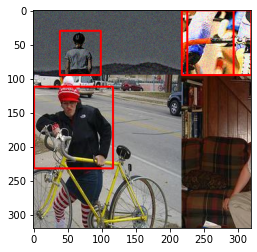

['resized_labeled_images\\16d0d4ec-f057-49e7-8a64-bcf6ddcc46a2.jpg', 'resized_labeled_images\\9215a3cc-d328-41d1-9dbf-299ae9dca3be.jpg', 'resized_labeled_images\\368e4bb0-be36-45b6-8ece-01cf377064b6.jpg', 'resized_labeled_images\\c64b1653-bba9-4baa-89b7-52bdd11bd1ab.jpg'] ['resized_labeled_images\\16d0d4ec-f057-49e7-8a64-bcf6ddcc46a2.json', 'resized_labeled_images\\9215a3cc-d328-41d1-9dbf-299ae9dca3be.json', 'resized_labeled_images\\368e4bb0-be36-45b6-8ece-01cf377064b6.json', 'resized_labeled_images\\c64b1653-bba9-4baa-89b7-52bdd11bd1ab.json']
[{'label': 'person', 'left': 0, 'top': 162.99622399999998, 'width': 170.934336, 'height': 157.00377600000002}, {'label': 'person', 'left': 151.52265599999998, 'top': 107, 'width': 29.477344000000016, 'height': 213}, {'label': 'person', 'left': 244.7888096, 'top': 19.128524800000008, 'width': 75.21119039999999, 'height': 87.87147519999999}, {'label': 'person', 'left': 184.1103008, 'top': 107, 'width': 135.8896992, 'height': 213}]


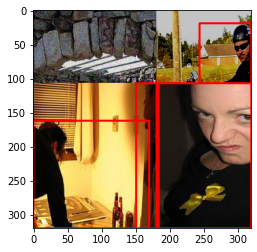

['resized_labeled_images\\c5267bc0-f8ad-4cf6-a3ee-7b2846d88f63.jpg', 'resized_labeled_images\\64553e0e-88df-4575-9dd3-9e4fce4fd5ad.jpg', 'resized_labeled_images\\ceae8b16-8b29-491f-b4bf-e250cd9a12be.jpg', 'resized_labeled_images\\3f703ccf-67fe-476a-a813-e69a5923064d.jpg'] ['resized_labeled_images\\c5267bc0-f8ad-4cf6-a3ee-7b2846d88f63.json', 'resized_labeled_images\\64553e0e-88df-4575-9dd3-9e4fce4fd5ad.json', 'resized_labeled_images\\ceae8b16-8b29-491f-b4bf-e250cd9a12be.json', 'resized_labeled_images\\3f703ccf-67fe-476a-a813-e69a5923064d.json']
[{'label': 'person', 'left': 30.598761600000003, 'top': 25.045504, 'width': 50.4012384, 'height': 64.55720000000002}, {'label': 'person', 'left': 81, 'top': 0, 'width': 63.7736896, 'height': 117.251584}, {'label': 'person', 'left': 94.630784, 'top': 0, 'width': 187.300992, 'height': 99.2678272}, {'label': 'person', 'left': 266.29376, 'top': 0, 'width': 53.70624000000001, 'height': 146.99872}, {'label': 'person', 'left': 81, 'top': 220, 'width': 6

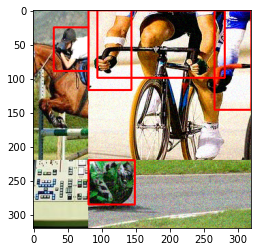

['resized_labeled_images\\938a3f76-74e3-4af6-bde0-d7b46bf9f593.jpg', 'resized_labeled_images\\a6c4d255-f86b-4614-ba10-32b2e4d16d0d.jpg', 'resized_labeled_images\\f50ced3a-3820-4e4e-a3ab-7dece9b16a05.jpg', 'resized_labeled_images\\58666e9d-e3a8-4961-92ec-d1f152e23951.jpg'] ['resized_labeled_images\\938a3f76-74e3-4af6-bde0-d7b46bf9f593.json', 'resized_labeled_images\\a6c4d255-f86b-4614-ba10-32b2e4d16d0d.json', 'resized_labeled_images\\f50ced3a-3820-4e4e-a3ab-7dece9b16a05.json', 'resized_labeled_images\\58666e9d-e3a8-4961-92ec-d1f152e23951.json']
[{'label': 'person', 'left': 0, 'top': 40.180352, 'width': 82, 'height': 84.35947519999999}, {'label': 'person', 'left': 0, 'top': 174, 'width': 64.5928768, 'height': 125.13264}, {'label': 'person', 'left': 82, 'top': 191.6660928, 'width': 96.14376, 'height': 101.755552}, {'label': 'person', 'left': 154.4723936, 'top': 191.91549759999998, 'width': 88.47462399999998, 'height': 98.2940576}]


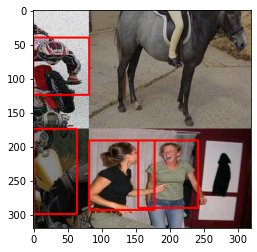

['resized_labeled_images\\5e4227a4-c18e-4061-980d-20c6d9df798e.jpg', 'resized_labeled_images\\d0126f1a-8a8a-4aab-9763-3c732d0f58b1.jpg', 'resized_labeled_images\\df2ee72d-f0df-4058-84b3-b45c33163ba1.jpg', 'resized_labeled_images\\81709ebc-6ffb-4ad2-b21a-88247636736e.jpg'] ['resized_labeled_images\\5e4227a4-c18e-4061-980d-20c6d9df798e.json', 'resized_labeled_images\\d0126f1a-8a8a-4aab-9763-3c732d0f58b1.json', 'resized_labeled_images\\df2ee72d-f0df-4058-84b3-b45c33163ba1.json', 'resized_labeled_images\\81709ebc-6ffb-4ad2-b21a-88247636736e.json']
[{'label': 'person', 'left': 60.194899199999995, 'top': 7.481430399999994, 'width': 186.8051008, 'height': 205.5185696}, {'label': 'person', 'left': 10.563164800000003, 'top': 0, 'width': 149.7716896, 'height': 213}, {'label': 'person', 'left': 171.56657919999998, 'top': 213, 'width': 59.9988352, 'height': 103.582496}, {'label': 'person', 'left': 247, 'top': 16.517318399999994, 'width': 73, 'height': 110.79184}]


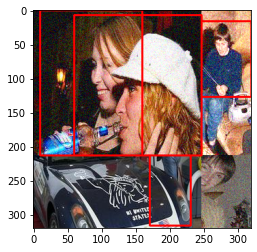

In [10]:
import os
import random
import json
import cv2 as cv
from datetime import datetime


def random_select_images_and_labels(folder_path, images_per_sample=4):

    image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    # 随机选择4张图片
    selected_images = random.sample(image_files, images_per_sample)

    img_path_list = []
    label_path_list = []
    for image in selected_images:
        image_path = os.path.join(folder_path, image)

        # 获取对应的JSON标签文件路径
        label_file = os.path.splitext(image)[0] + '.json'
        label_path = os.path.join(folder_path, label_file)

        # 读取JSON标签文件内容
        with open(label_path, 'r') as label_file:
            label_data = json.load(label_file)
            
        # 保存图片和标签
        img_path_list.append(image_path)
        label_path_list.append(label_path)
        
    return img_path_list, label_path_list 

def parse_label_file(label_file):
    with open(label_file, 'r') as f:
        return json.load(f)            


def apply_random_augmentation(img, labels):
    # 定义增强函数列表
    # augmentation_functions = [add_noise, adjust_brightness, rescale_image_and_labels, color_jitter]
    augmentation_functions = [add_noise, adjust_brightness, color_jitter]

    # 随机确定应用增强的数量
    num_augmentations = random.randint(0, len(augmentation_functions))

    # 随机选择并应用增强函数
    augmented_img = img
    augmented_labels = labels
    selected_augmentations = random.sample(augmentation_functions, num_augmentations)
    for augmentation_function in selected_augmentations:
        augmented_img, augmented_labels = augmentation_function(augmented_img, augmented_labels)

    return augmented_img, augmented_labels

        
def main():
    # 指定原始图像文件夹和增强后保存的文件夹
    original_images_folder = "resized_labeled_images"
    augmented_images_folder = "augmented_labeled_images"

    # 如果保存文件夹不存在，创建它
    if not os.path.exists(augmented_images_folder):
        os.makedirs(augmented_images_folder)

    num_samples=10
    for _ in range(num_samples):
    # 获取文件夹中的所有图片文件
        img_path_list, label_path_list = random_select_images_and_labels(original_images_folder)
        print(img_path_list, label_path_list)

        labels = [parse_label_file(label_file) for label_file in label_path_list]
        image_files = [cv.imread(image_file) for image_file in img_path_list]
        Augmented_imgs = []
        Augmented_labels = []
        for i in range(4):
            new_img, new_labels = apply_random_augmentation(image_files[i], labels[i])
            Augmented_imgs.append(new_img)
            Augmented_labels.append(new_labels)
        mosaic_image, mosaic_labels = random_mosaic(Augmented_imgs, Augmented_labels)
        
        # save image
        current_time = datetime.now().strftime("%Y%m%d%H%M%S")
        img_path_name = os.path.join(augmented_images_folder,'mosaic_{}.jpg'.format(current_time))
        cv.imwrite(img_path_name, cv.cvtColor(mosaic_image, cv.COLOR_BGR2RGB))
        # save labels
        with open(os.path.join(augmented_images_folder,'mosaic_{}.json'.format(current_time)), 'w') as outfile:
            json.dump(mosaic_labels, outfile)
        
        # show image and labels
        # mosaic_image.show()
        print(mosaic_labels)
        # 遍历 bounding boxes 并画出每个 bounding box
        for label in mosaic_labels:
            left = int(label["left"])
            top = int(label["top"])
            right = int(label["left"] + label["width"])
            bottom = int(label["top"] + label["height"])

            # 画矩形框
            cv.rectangle(mosaic_image, (left, top), (right, bottom), (255, 0, 0), 2)

        # 显示图像
        plt.imshow(mosaic_image)
        plt.show()
        
    
if __name__ == "__main__":
    main()